In [8]:
import tqdm
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import shutil
import os

In [9]:
def get_or_else(d, key, default):
    if key in d:
        return d[key]
    else:
        return default


Image number: 1 Annotation key: 1.jpg143451
General info:
{"fileref": "", "size": 143451, "filename": "1.jpg", "base64_img_data": "", "file_attributes": {"width": 1280, "height": 720}, "regions": {"0": {"shape_attributes": {"name": "polygon", "all_points_x": [937, 999, 1010, 947, 937], "all_points_y": [214, 207, 271, 277, 214]}, "region_attributes": {"name": "road sign"}}, "1": {"shape_attributes": {"name": "polygon", "all_points_x": [665, 674, 687, 665], "all_points_y": [387, 365, 386, 387]}, "region_attributes": {"name": "road sign"}}, "2": {"shape_attributes": {"name": "polygon", "all_points_x": [664, 684, 685, 665, 664], "all_points_y": [395, 394, 404, 405, 395]}, "region_attributes": {"name": "road sign"}}, "3": {"shape_attributes": {"name": "polygon", "all_points_x": [1001, 974, 981, 1007, 1001], "all_points_y": [471, 275, 275, 471, 471]}, "region_attributes": {"name": "road sign"}}, "4": {"shape_attributes": {"name": "polygon", "all_points_x": [679, 673, 677, 683, 679], "all_poi

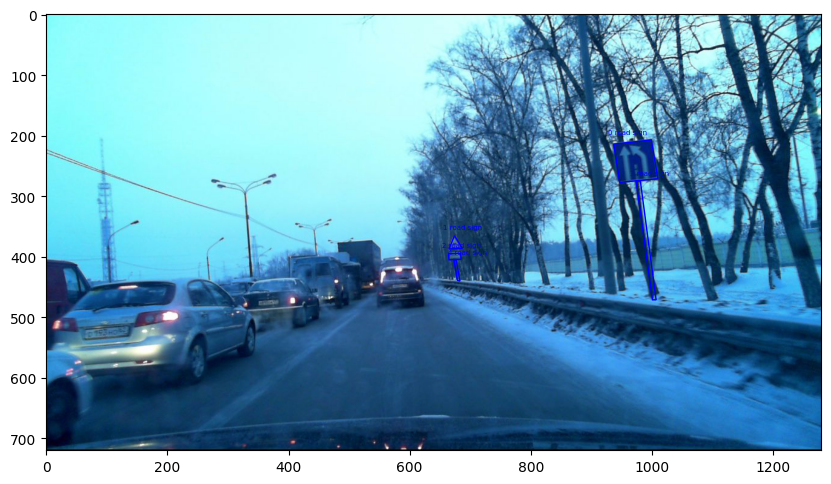

In [10]:
img_number = 1
folder = 'data/sign_dataset/train'
with open(f'{folder}/{img_number}.jpg_coco.json') as fst_photo:
    photo_annot = json.load(fst_photo)

annot_key = [key for key in all_a.keys() if key.startswith(f"{img_number}.jpg")][0]
print(f"Image number: {img_number} Annotation key: {annot_key}")
photo_info = all_a[annot_key]
print(f"General info:\n{json.dumps(photo_info)}")


filename = photo_info['filename']
img = Image.open(f'{folder}/{filename}')
fig, ax = plt.subplots(1, figsize = (10, 10))
ax.imshow(img)


for (reg, reg_data) in photo_info['regions'].items():
    text_annot = str(reg) + " " + get_or_else(reg_data['region_attributes'], 'name', '')
    shape = reg_data['shape_attributes']

    if shape['name'] == "ellipse":
        cx, cy, rx, ry = (shape['cx'], shape['cy'], shape['rx'], shape['ry'])
        el = patches.Ellipse((cx, cy), rx * 2, ry * 2, linewidth=1, edgecolor='blue', facecolor='none')
        ax.text(cx - rx - 10, cy - ry - 10, text_annot, color='blue', fontsize=5)
        ax.add_patch(el)
    elif shape['name'] == "circle":
        cx, cy, r = (shape['cx'], shape['cy'], shape['r'])
        el = patches.Ellipse((cx, cy), r * 2, r * 2, linewidth=1, edgecolor='blue', facecolor='none')
        ax.text(cx - rx - 10, cy - ry - 10, text_annot, color='blue', fontsize=5)
        ax.add_patch(el)
    elif shape['name'] == "rect":
        x, y, w, h = (shape['x'], shape['y'], shape['width'], shape['height'])
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='blue', facecolor='none')
        ax.text(x - 10, y - 10, text_annot, color='blue', fontsize=5)
        ax.add_patch(rect)
    elif shape['name'] == "polygon": 
        xs, ys = (shape['all_points_x'], shape['all_points_y'])
        pol = patches.Polygon(np.array([xs, ys]).transpose(), closed = True, linewidth=1, edgecolor='blue', facecolor='none')
        x_min = np.min(xs)
        y_min = np.min(ys)
        ax.text(x_min - 10, y_min - 10, text_annot, color='blue', fontsize=5)
        ax.add_patch(pol)
    else:
        raise AssertionError(f"Unknown shape: {shape}")

plt.show()

In [11]:
def flatten_list(list):
    return [item for sublist in list for item in sublist]

def polygon_to_poly(xs, ys):
    poly = list(zip(xs, ys))
    if poly[0] == poly[-1]:
        poly = poly[:-1]
    return poly

def rectangle_to_poly(x, y, w, h):
    return [(x, y), (x + w, y), (x + w, y + h), (x, y + h)]

def circle_to_poly(cx, cy, r):
    return [(cx + r * np.cos(a), cy - r * np.sin(a)) for a in np.arange(0, 2 * np.pi, 0.1)]

def ellipse_to_poly(cx, cy, rx, ry):
    return [(cx + rx * np.cos(a), cy - ry * np.sin(a)) for a in np.arange(0, 2 * np.pi, 0.1)]

def polygon_area(xs, ys):
    return 0.5 * np.abs(np.dot(xs, np.roll(ys, 1)) - np.dot(ys, np.roll(xs, 1)))

def convert_annot_to_yolo(folder, annot_file, out_folder):
    data_infos = json.load(open(folder + annot_file, 'r'))

    annotations = []
    images = []
    obj_count = 0
    for idx, info in enumerate(data_infos.values()):
        filename = info['filename']
        height, width = (info['file_attributes']['height'], info['file_attributes']['width'])

        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))

        
        content = []
        for region in info['regions'].values():
            shape = region['shape_attributes']
            poly = None
            area = None
            if shape['name'] == "ellipse":
                cx, cy, rx, ry = (shape['cx'], shape['cy'], shape['rx'], shape['ry'])
                poly = ellipse_to_poly(cx, cy, rx, ry)
                area = np.pi * rx * ry
            elif shape['name'] == "circle":
                cx, cy, r = (shape['cx'], shape['cy'], shape['r'])
                poly = circle_to_poly(cx, cy, r)
                area = np.pi * r * r
            elif shape['name'] == "rect":
                x, y, w, h = (shape['x'], shape['y'], shape['width'], shape['height'])
                poly = rectangle_to_poly(x, y, w, h)
                area = w * h
            elif shape['name'] == "polygon": 
                xs, ys = (shape['all_points_x'], shape['all_points_y'])
                poly = polygon_to_poly(xs, ys)
                area = polygon_area(xs, ys)
            else:
                raise AssertionError(f"Unknown shape: {shape}")
            
            poly = np.array(poly, dtype=float)
            x_min, y_min, x_max, y_max = (
                int(min(poly[:, 0])),
                int(min(poly[:, 1])),
                int(max(poly[:, 0])),
                int(max(poly[:, 1]))
                )

            annotations.append(dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=area,
                segmentation=[[int(x) for x in flatten_list(poly)]],
                iscrowd=0))
            obj_count += 1

            poly[:, 0] = poly[:, 0] / width
            poly[:, 1] = poly[:, 1] / height
            content.append(f'0 {" ".join([str(i) for i in poly.ravel()])}')

        with open(f'{out_folder}/{filename[:-4]}.txt', 'w') as f:
            f.write('\n'.join(content))


In [22]:
for folder, dir, files in os.walk('./data/sign_dataset/train/'):
    for f in files:
        if f.endswith('.jpg'):
            shutil.copy(f'{folder}/{f}', f'./data/yolov8_f/train/images')

In [24]:
convert_annot_to_yolo('data/sign_dataset/train/', 'via_region_data.json', './data/yolov8_f/train/labels')